<a href="https://www.kaggle.com/code/adityapatidar7/recommendation?scriptVersionId=171501174" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# importing and installing library

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD


# 1. BUSINESS UNDERSTANDING :

* Objectives :-The objective of this recommendation system implementation is to enhance the user experience on the e-commerce site by providing personalized product recommendations. Specifically, we aim to leverage item-based collaborative filtering to achieve a significant improvement in key performance indicators.

* Target Improvement :- Our target is to realize a 15% increase in user engagement or a 10% increase in conversion rates, thereby saving consumer time and contributing to the overall success of the client's business.

# 2.DATA UNDERSTANDING :


The dataset consists of three files: a file with behaviour data (events.csv), a file with item properties (item_properties.сsv) and a file, which describes category tree (category_tree.сsv). The data has been collected from a real-world ecommerce website
we will use file with behaviour data (events.csv) because we will performe collaborative filtering so there is only columns need is user and items and there interaction value which available in events data iteslf, so we will ignore rest file

# 3.Data Exploration and Visualization :

**Events Data Analysis :**

In [2]:
# Read the Data

event_data = pd.read_csv('/kaggle/input/ecommerce-dataset/events.csv')


In [3]:
event_data.shape

(2756101, 5)

so we have 2756101 rows and 5 columns. now lets see which columns name and values of row

In [4]:
event_data.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


* The timestamp portion is time at which user was on platform
* Visitor Id is the unique user currently browsing the website
* Event is what the user is currently doing in that current timestamp
* Transaction ID will only have value if the user made a purchase as shown below

In [5]:
#sort event because events take place one by one with respect to time

event_data = event_data.sort_values(by=['visitorid', 'timestamp']).reset_index(drop=True)
event_data.head()

,timestamp,visitorid,event,itemid,transactionid
0,1442004589439,0,view,285930,NaN
1,1442004759591,0,view,357564,NaN
2,1442004917175,0,view,67045,NaN
3,1439487966444,1,view,72028,NaN
4,1438969904567,2,view,325215,NaN


In [6]:
uniq_visitor = event_data['visitorid'].nunique()
total_visitor = event_data['visitorid'].size

print(f'total visitor:{total_visitor}')
print(f'unique visitor:{uniq_visitor}')


total visitor:2756101
unique visitor:1407580


In [7]:
#check null values

event_data.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

In [8]:
#check how many item customer purchased

costomer_purchased = event_data[event_data['transactionid'].notnull()].visitorid.nunique()
costomer_purchased

11719

so out of 1,407,580 visitors, ony 11,719 bought something so around 1,395,861 visitors just viewed items

In [9]:
#check duplicates 

event_data.duplicated().sum()

460

In [10]:
#remove duplicates 

event_data.drop_duplicates(keep='first', inplace=True)

In [11]:
#check value count of event column

event_count = event_data['event'].value_counts()
event_count

event
view           2664218
addtocart        68966
transaction      22457
Name: count, dtype: int64

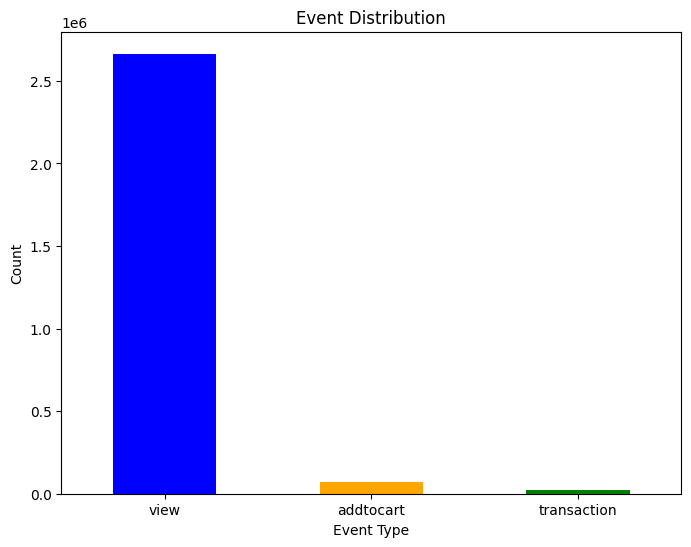

In [12]:
#visualizing event distribution

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
event_data['event'].value_counts().plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Event Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

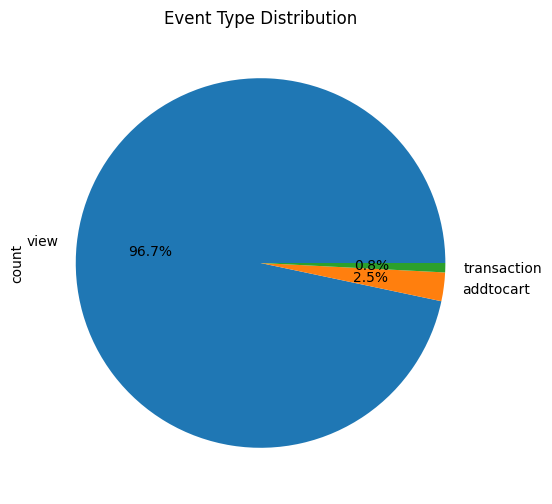

In [13]:
#percentage wise distribution showed 

event_percentage = event_count / len(event_data)
plt.figure(figsize=[6,6])
event_percentage.plot(kind='pie', autopct='%1.1f%%')
plt.title('Event Type Distribution')
plt.show()

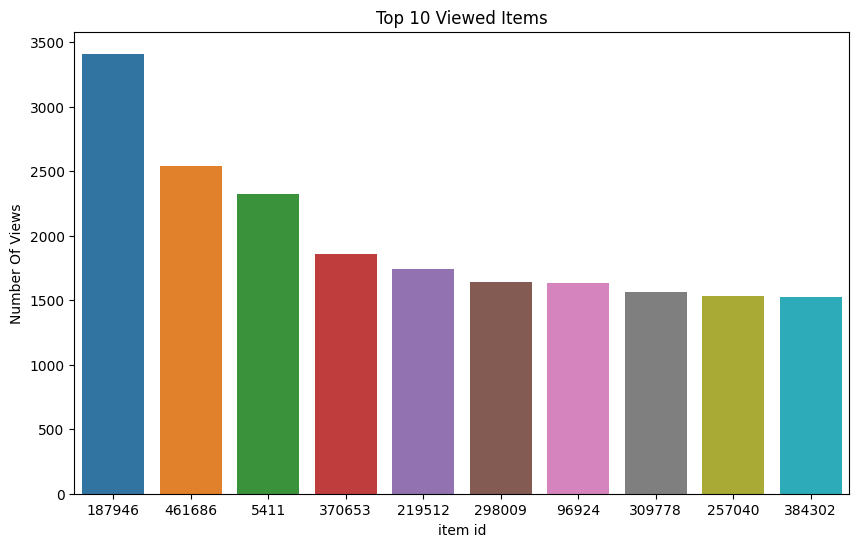

In [14]:
# top viewed items

top_viewed_items = event_data[event_data['event']=='view']['itemid'].value_counts().head(10)
top_viewed_items = top_viewed_items.sort_values(ascending= False)
plt.figure(figsize=(10,6))
sns.barplot(x=top_viewed_items.index, y=top_viewed_items.values, order = top_viewed_items.index)
plt.title('Top 10 Viewed Items')
plt.xlabel('item id')
plt.ylabel('Number Of Views')
plt.show()

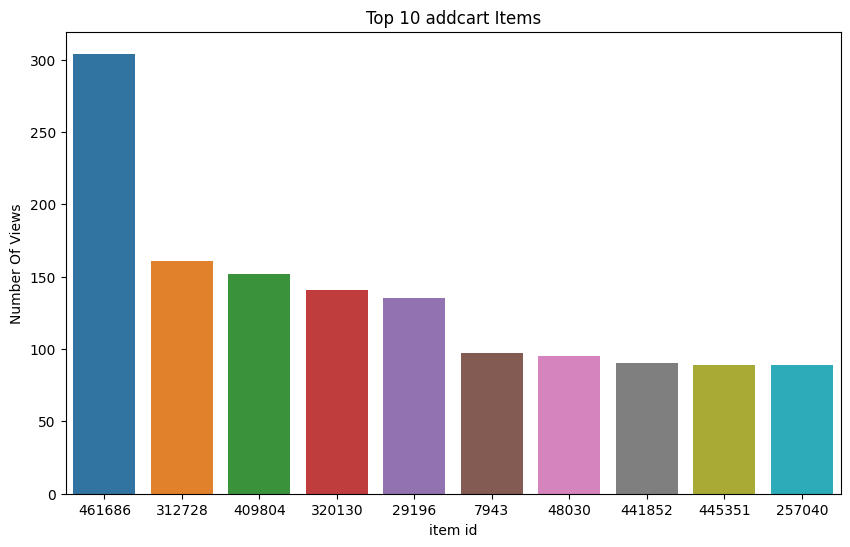

In [15]:
# top items added to cart

top_addcart_items = event_data[event_data['event']=='addtocart']['itemid'].value_counts().head(10)
top_addcart_items = top_addcart_items.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=top_addcart_items.index, y=top_addcart_items.values, order=top_addcart_items.index)
plt.title('Top 10 addcart Items')
plt.xlabel('item id')
plt.ylabel('Number Of Views')
plt.show()

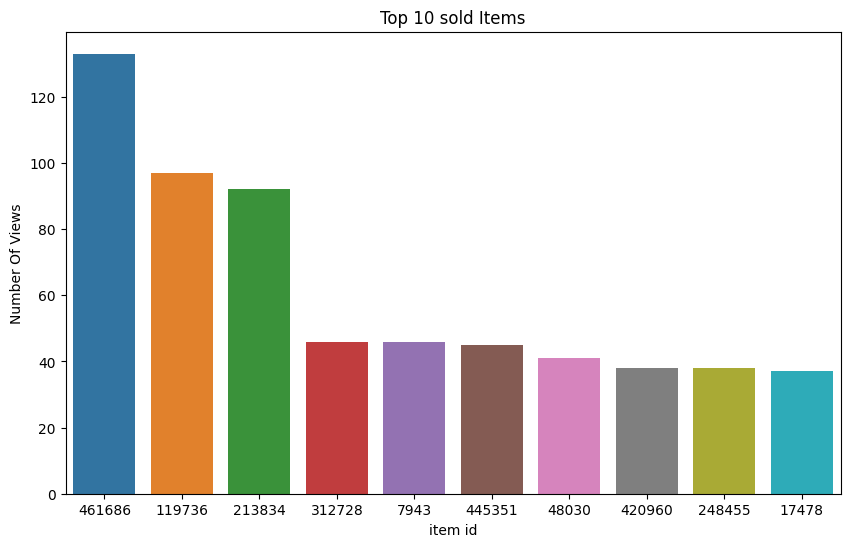

In [16]:
#top sold items 

top_sold_items = event_data[event_data['event']=='transaction']['itemid'].value_counts().head(10)
top_sold_items = top_sold_items.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=top_sold_items.index, y=top_sold_items.values, order=top_sold_items.index)
plt.title('Top 10 sold Items')
plt.xlabel('item id')
plt.ylabel('Number Of Views')
plt.show()

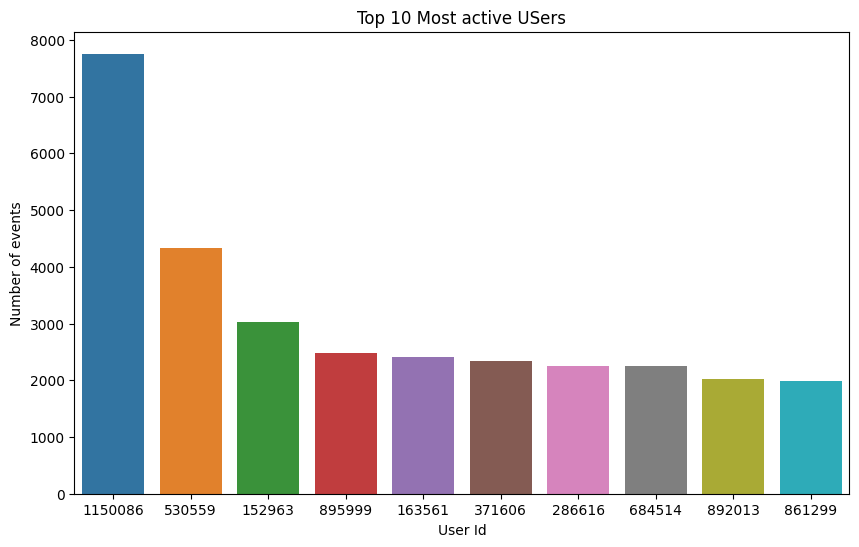

In [17]:
# few most active users

top_active_users=event_data['visitorid'].value_counts().head(10)
top_active_users = top_active_users.sort_values(ascending=False)


plt.figure(figsize=(10,6))
sns.barplot(x=top_active_users.index, y=top_active_users.values, order=top_active_users.index)
plt.title('Top 10 Most active USers')
plt.xlabel('User Id')
plt.ylabel('Number of events')
plt.show()

# 4.collaborative filtering : item-based

We want to suggest the User a item, that may be added to the cart. Based on item based collaborative filtering.

* **PRE-PROCESSING**

In [18]:
#creating new dataframe to aggregate and organize the event data by visitor, item, and event type, 
#providing a more structured and condensed representation of the information for further analysis

visitor_item_event_df = event_data.groupby(['visitorid', 'itemid', 'event'])['timestamp'].count().to_frame().reset_index()
visitor_item_event_df.head()

,visitorid,itemid,event,timestamp
0,0,67045,view,1
1,0,285930,view,1
2,0,357564,view,1
3,1,72028,view,1
4,2,216305,view,2


In [19]:
visitor_item_event_df.shape

(2215422, 4)

In [20]:
# T0 make things run faster lets sample few items

np.random.seed(1)
items_to_keep = np.random.choice(visitor_item_event_df['itemid'].unique(), size=100000, replace=False)
visitor_item_event_df = visitor_item_event_df[visitor_item_event_df['itemid'].isin(items_to_keep)]

In [21]:
#lets get addtocart event only

visitor_item_df = visitor_item_event_df[visitor_item_event_df['event'] == 'addtocart']
visitor_item_df.head()

,visitorid,itemid,event,timestamp
207,155,41882,addtocart,1
213,155,181405,addtocart,1
215,155,368372,addtocart,1
217,155,389974,addtocart,1
379,264,161949,addtocart,1


In [22]:
visitor_item_df.shape

(26785, 4)

* **CREATE METRICS**

In [23]:
#convert long data into wide range for details of user based colaborative 

item_wise_df = visitor_item_df.pivot(index='itemid', columns='visitorid', values='timestamp')
item_wise_df

visitorid,155,264,419,420,539,588,627,648,795,878,...,1407037,1407059,1407064,1407070,1407110,1407129,1407355,1407430,1407512,1407515
itemid,,,,,,,,,,,,,,,,,,,,,
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
466685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
466688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* **MEAN CENTERING:**

**AS WE SEE LOT OF NAN VALUE AVAILBLE IN OUR DATASET SO TO NORMALIZE AND ADDRESSING SPARSITY FILLING MISSING VALUE WITH NEUTRAL SCORES BY PERFORMING MEAN CENTERING **

In [24]:
#subtracting the mean of the addtocart from each individual data point

avg_addcarts = item_wise_df.sum() / item_wise_df.shape[1]
visitor_item_raw_df = item_wise_df.copy()
item_wise_df = item_wise_df.sub(avg_addcarts, axis=1)
item_wise_df = item_wise_df.fillna(0)
item_wise_df.head()


visitorid,155,264,419,420,539,588,627,648,795,878,...,1407037,1407059,1407064,1407070,1407110,1407129,1407355,1407430,1407512,1407515
itemid,,,,,,,,,,,,,,,,,,,,,
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
#we addressed that our data has sparsity so calculating sparsity percentage

not_empty = visitor_item_raw_df.notnull().values.sum()
total_number = visitor_item_raw_df.size
print(100 * not_empty/total_number)

0.014052655828659695


This suggests that 99.86% of the entries in our DataFrame are empty or missing.
so we will not able to recommend items using KNN so will use ALTERNATE LEAST SQUARE Model but before that we will check cosine similarity between item for better recommendations.

* **COSINE SIMILARITY**

In [26]:
#finding similarities based on item-wise

similarities = cosine_similarity(item_wise_df)
consine_similarity_df = pd.DataFrame(similarities, 
                                    index=item_wise_df.index.values,
                                    columns=item_wise_df.index.values)
consine_similarity_df.head()

,25,33,66,168,212,216,233,315,350,361,...,466301,466335,466385,466464,466472,466614,466685,466688,466710,466747
25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
212,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#lets check similar products to itemid 2416

consine_similarity_df[461686].sort_values(ascending=False).head(10)


461686    1.000000
171878    0.309607
198041    0.291444
32581     0.282786
40630     0.238182
362495    0.205020
95914     0.193517
199394    0.193517
279257    0.193517
361152    0.193517
Name: 461686, dtype: float64

* ****MATRIX  FACTORIZATION:****

***Singular value decomposition

In [28]:
# Convert DataFrame to Sparse Matrix

item_wise_sparse = csr_matrix(item_wise_df) 
U, sigma, Vt = svds(item_wise_sparse)

In [29]:
#multiply decompose matrixes to get filled matrix

filled_matrix = np.dot(np.dot(U, np.diag(sigma)), Vt)
filled_matrix = filled_matrix + avg_addcarts.values.reshape(1, -1)
pd.DataFrame(filled_matrix,
            index=visitor_item_raw_df.index,
            columns=visitor_item_raw_df.columns)

visitorid,155,264,419,420,539,588,627,648,795,878,...,1407037,1407059,1407064,1407070,1407110,1407129,1407355,1407430,1407512,1407515
itemid,,,,,,,,,,,,,,,,,,,,,
25,0.000213,0.000107,0.000053,0.000213,0.000107,0.000053,0.000053,0.000053,0.000053,0.000053,...,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000213,0.000053
33,0.000213,0.000107,0.000053,0.000213,0.000107,0.000053,0.000053,0.000053,0.000053,0.000053,...,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000213,0.000053
66,0.000213,0.000107,0.000053,0.000213,0.000107,0.000053,0.000053,0.000053,0.000053,0.000053,...,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000213,0.000053
168,0.000213,0.000107,0.000053,0.000214,0.000131,0.000053,0.000053,0.000054,0.000077,0.000098,...,0.000058,0.000053,0.000062,0.000087,0.000077,0.000132,0.000053,0.000230,0.000213,0.000053
212,0.000213,0.000107,0.000053,0.000213,0.000107,0.000053,0.000053,0.000053,0.000053,0.000054,...,0.000053,0.000053,0.000053,0.000054,0.000053,0.000053,0.000053,0.000054,0.000213,0.000053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466614,0.000213,0.000107,0.000053,0.000213,0.000115,0.000053,0.000053,0.000054,0.000058,0.000081,...,0.000055,0.000053,0.000053,0.000066,0.000059,0.000035,0.000053,0.000149,0.000213,0.000053
466685,0.000213,0.000107,0.000053,0.000213,0.000107,0.000053,0.000053,0.000053,0.000053,0.000060,...,0.000053,0.000053,0.000053,0.000054,0.000054,0.000051,0.000053,0.000069,0.000213,0.000053
466688,0.000213,0.000107,0.000053,0.000213,0.000107,0.000053,0.000053,0.000053,0.000053,0.000053,...,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000213,0.000053


In [30]:
# Generate Train and Test Data using random sample

np.random.seed(42)
mask = np.random.choice([False, True], size=item_wise_df.shape, p=[0.2, 0.8])
train_data = np.where(mask, item_wise_sparse.A, 0)
test_data = np.where(~mask, item_wise_sparse.A, 0)


In [31]:
# Perform SVD on the training data

item_wise_sparse = csr_matrix(item_wise_df)

U, sigma, Vt = svds(train_data)

# Predict missing values using the dot product of left and right singular vectors
predicted_matrix = np.dot(U, np.dot(np.diag(sigma), Vt))


* **EVOLUTION METRICS**

In [32]:
Rmse = np.sqrt(mean_squared_error(test_data[test_data != 0], predicted_matrix[test_data != 0]))
print(Rmse)

1.1815408325797445


The MSE provides a quantitative measure of the model's performance, indicating how well the predicted interactions align with the actual interactions in the test data.


In [33]:
model = TruncatedSVD()
model.fit(train_data)

TruncatedSVD()